# Supervised learning for the classification of Diabetes mellitus (Type 2 diabetes)

## Package imports

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, f1_score, make_scorer

from imblearn.over_sampling import SMOTE

from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC 
# SVC meaning support vector CLASSIFIER rather than machine.

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer

import missingno

## Ingestion and Integration

In [2]:
pima_df = pd.read_csv("Data/pima.csv")
pima_df.shape

(768, 9)

In [3]:
frankfurt_df = pd.read_csv("Data/frankfurt.csv")
frankfurt_df.shape

(2000, 9)

In [4]:
df = pd.concat([pima_df, frankfurt_df], axis = 0, ignore_index = True)
df.shape

(2768, 9)

In [5]:
pima_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
frankfurt_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


## Exploratory Data Analysis (EDA)

### Splitting the data

In [127]:
X = df.drop(columns = "Outcome", axis = 1)
y = df["Outcome"]

In [128]:
print(X.shape)
print(y.shape) # No columns because y is now a Series consisting only of the Outcome column.

(2768, 8)
(2768,)


In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [10]:
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (2214, 8)
y_train: (2214,)
X_test: (554, 8)
y_test: (554,)


If only X_train is used, we will not be able to perform a detailed analysis based that includes the outcome, as this is specifically excluded from X_train. Therefore, a new DataFrame consisting of a deep copy of X_train with the Outcome column of y_train readded is created for the purpose of this EDA section.

In [11]:
# It's important to make a deep copy, so that none of the data is tampered with.
fullTrainSet = X_train.copy(deep = True)
fullTrainSet["Outcome"] = y_train.values

### Missing value identification

In [12]:
fullTrainSet.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

It appears that there are no missing values. This is excellent! But is it actually true?

Let's look at the description of the dataset to get a feel for the values in each column to answer this.

In [13]:
fullTrainSet.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,2214.000000,2214.000000,2214.000000,2214.000000,2214.000000,2214.000000,2214.000000,2214.000000,2214.000000
mean,3.780036,121.210479,69.093496,20.599819,79.662150,32.058988,0.473864,33.284101,0.345528
std,3.321450,31.967589,19.319345,16.041849,111.192963,8.091686,0.328880,11.826703,0.475648
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,27.300000,0.244000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,40.000000,32.050000,0.375500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,32.000000,129.750000,36.600000,0.629000,41.000000,1.000000
max,17.000000,199.000000,122.000000,110.000000,846.000000,80.600000,2.420000,81.000000,1.000000


There is impossible data shown in this description, namely values of zero in the following columns:
- Glucose
- BloodPressure
- SkinThickness
- Insulin
- BMI

If any of these truly were 0 in a person, the person would not be alive.
These datasets do not include information on deceased patients. 

Therefore, this data can be interpreted as **missing data**,
and reformatted to the recognised NumPy NaN value.

In [14]:
X_train[["Glucose","Insulin","BloodPressure","SkinThickness","BMI"]] = X_train[["Glucose","Insulin","BloodPressure","SkinThickness","BMI"]].replace(0, np.nan)
# These changes also need to be made to the full training set.
fullTrainSet[["Glucose","Insulin","BloodPressure","SkinThickness","BMI"]] = fullTrainSet[["Glucose","Insulin","BloodPressure","SkinThickness","BMI"]].replace(0, np.nan)
# Assuming that this issue is present in the testing set, it should also be fixed there.
X_test[["Glucose","Insulin","BloodPressure","SkinThickness","BMI"]] = X_test[["Glucose","Insulin","BloodPressure","SkinThickness","BMI"]].replace(0, np.nan)

After performing this modification, the true missing value counts can be seen:

In [15]:
fullTrainSet.isna().sum()

Pregnancies                    0
Glucose                       13
BloodPressure                101
SkinThickness                652
Insulin                     1060
BMI                           34
DiabetesPedigreeFunction       0
Age                            0
Outcome                        0
dtype: int64

#### Missing values in the Insulin column

A likely assumption to be made is that the zeroes correspond to imperceptible levels of insulin. This is untrue, and they are missing data. 

Please see Appendix A of the accompanying report for a more detailed explanation with sources.

### Missingno Graphs

On this bar chart, the numbers above each bar are how many rows are present, and not how many are missing. The counts of the missing values were shown in the previous cell 
"df.isna().sum()"

<Axes: >

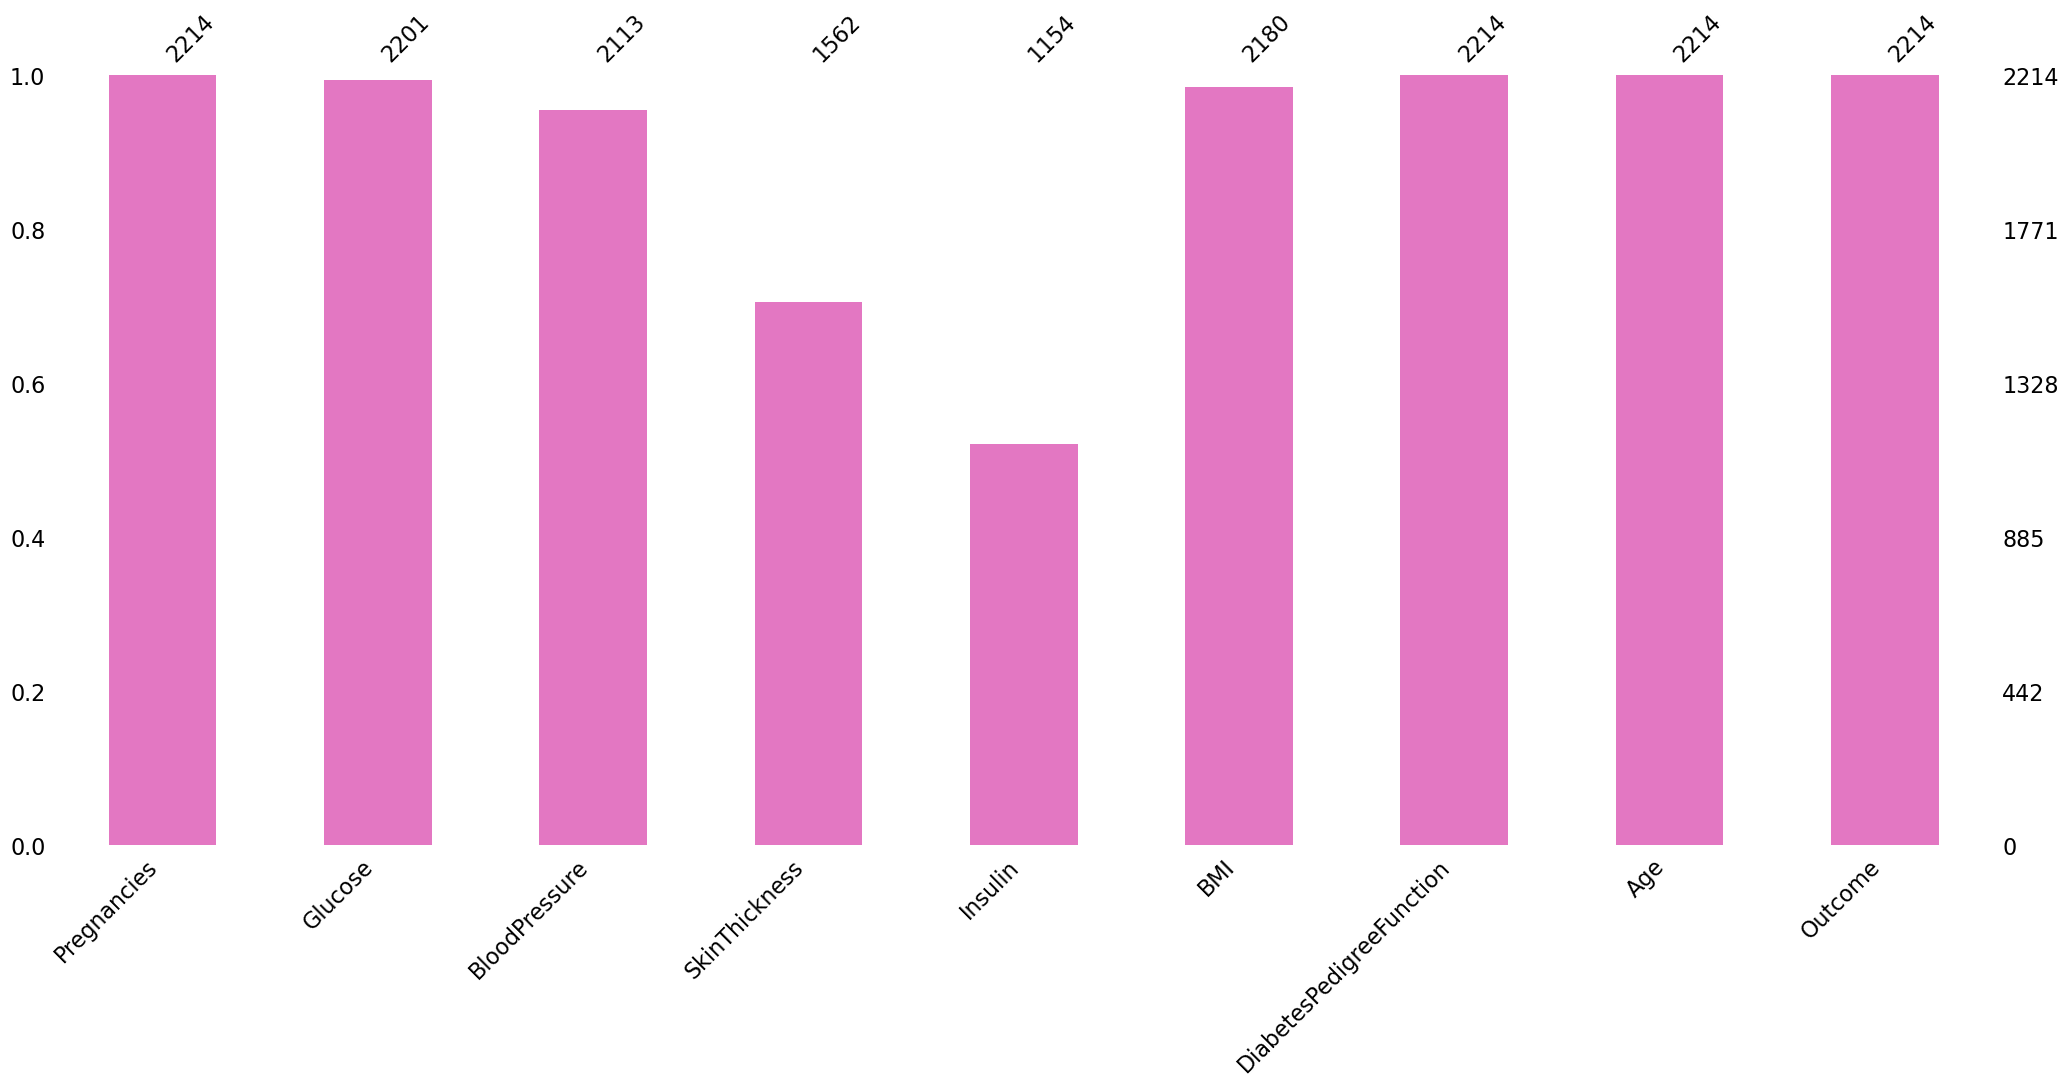

In [16]:
missingno.bar(fullTrainSet, color = "tab:pink")

<Axes: >

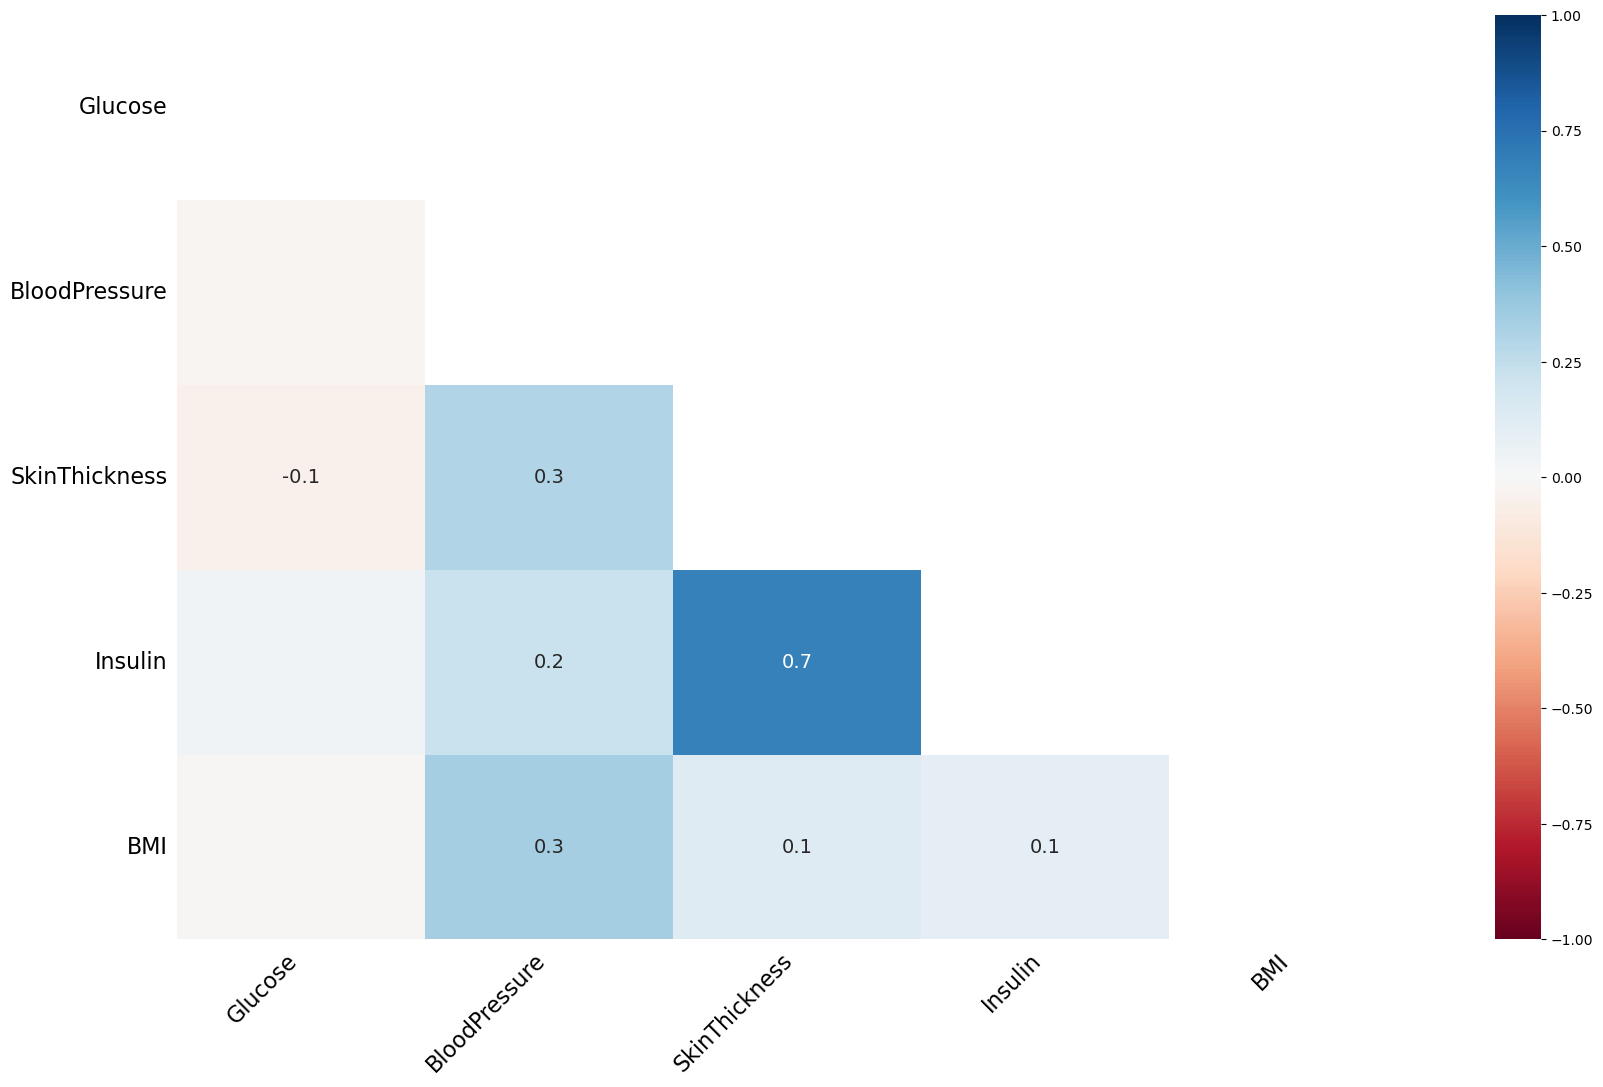

In [17]:
# This isn't used in the report, but shows the proportions of data where 
# one feature is also missing another feature.
missingno.heatmap(fullTrainSet)

<Axes: >

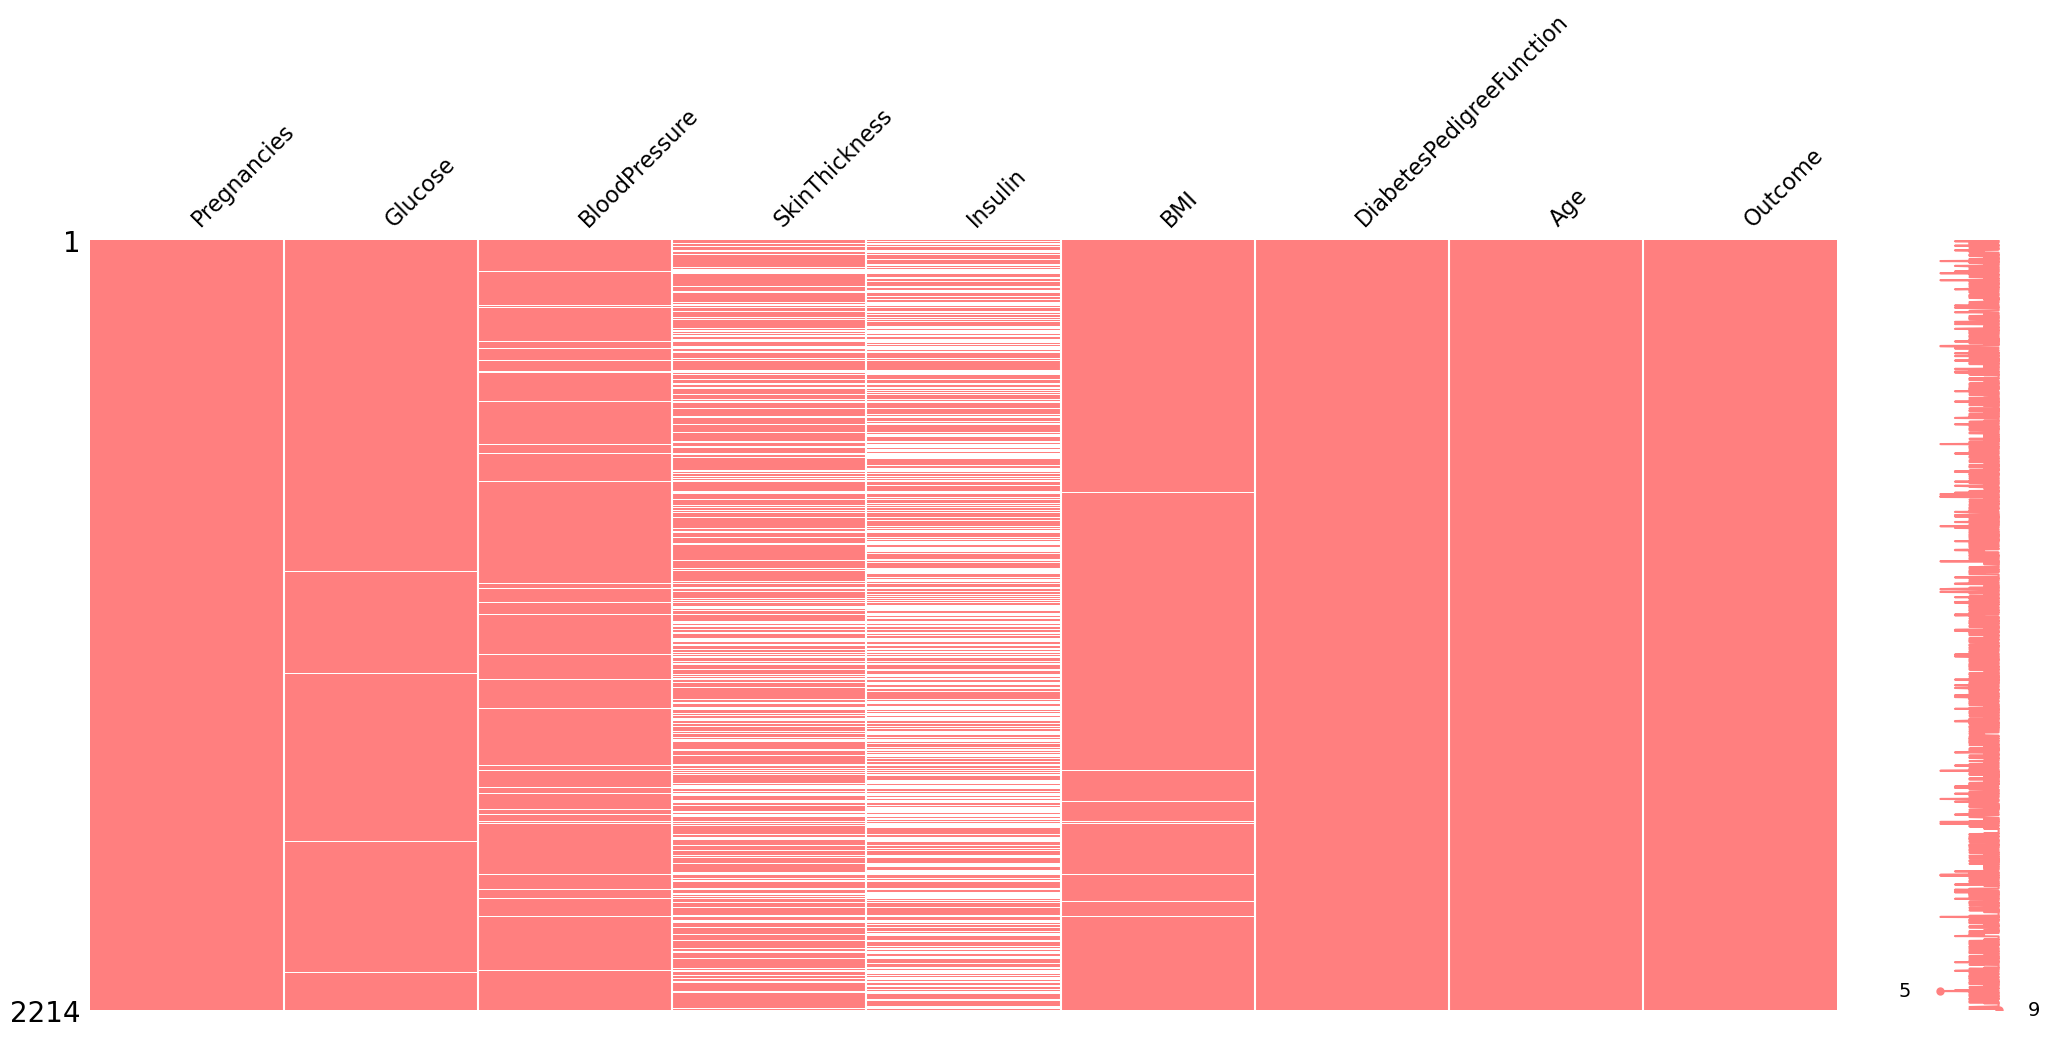

In [18]:
missingno.matrix(fullTrainSet, color = (1, 0.5, 0.5)) # Missingno's matrix colors are RGB from 0 to 1.

### Univariate boxplots

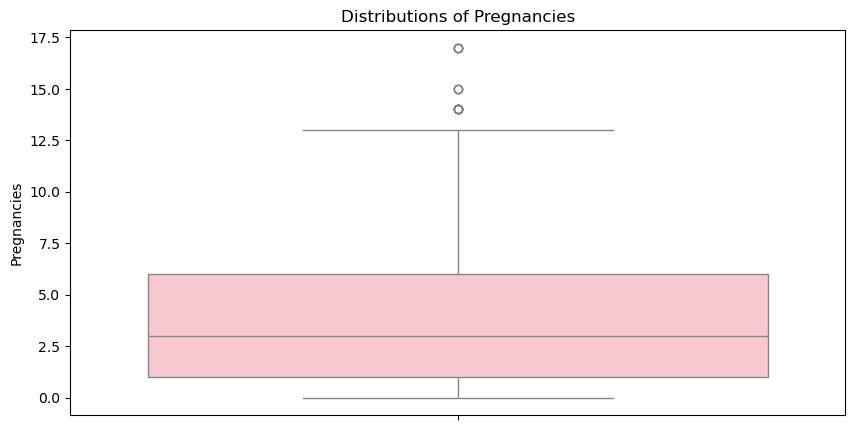

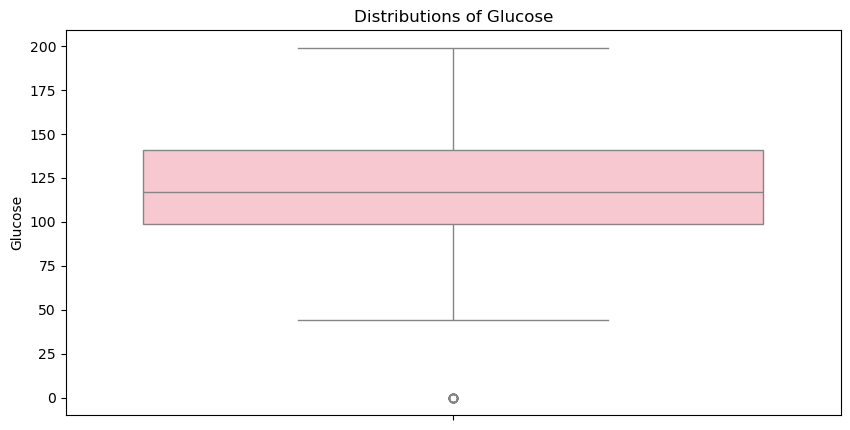

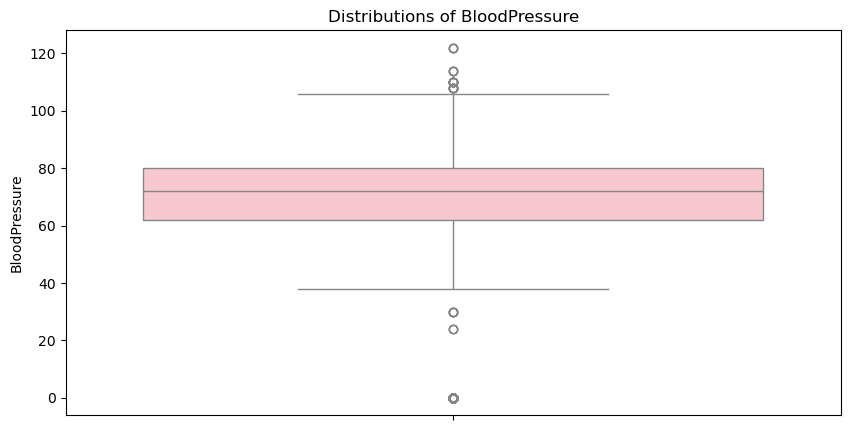

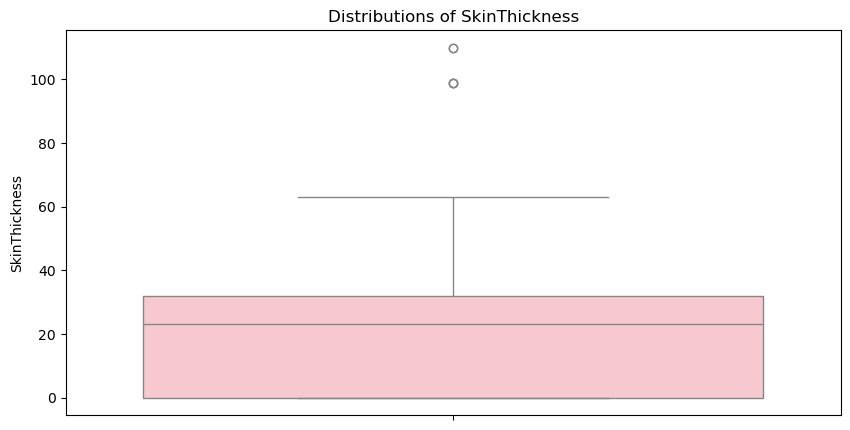

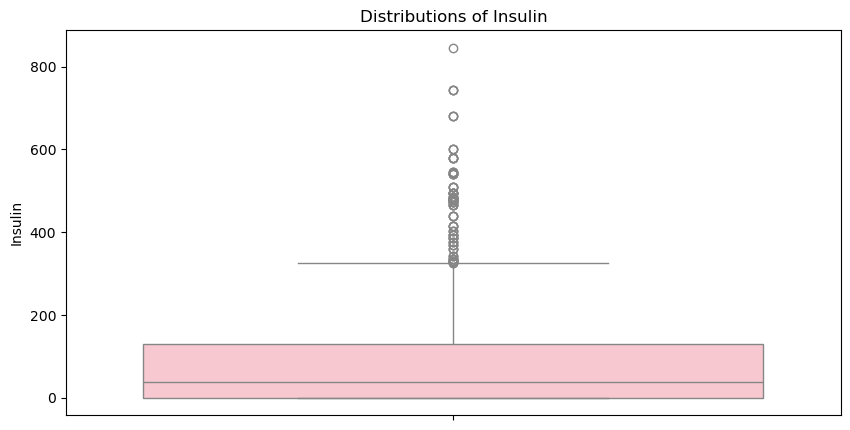

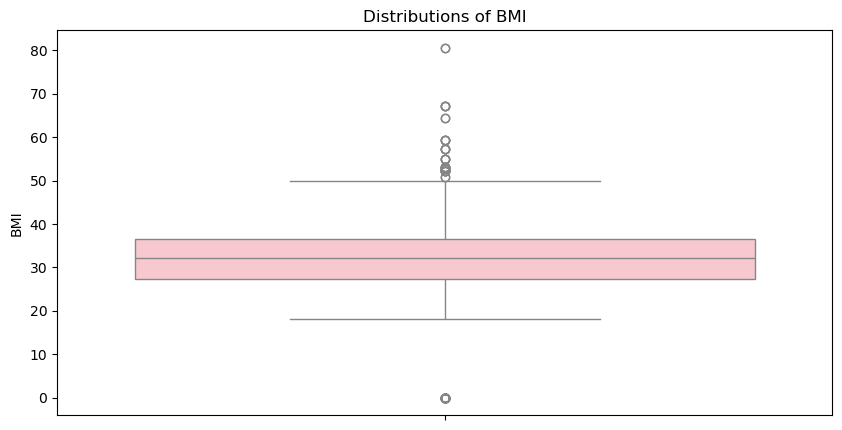

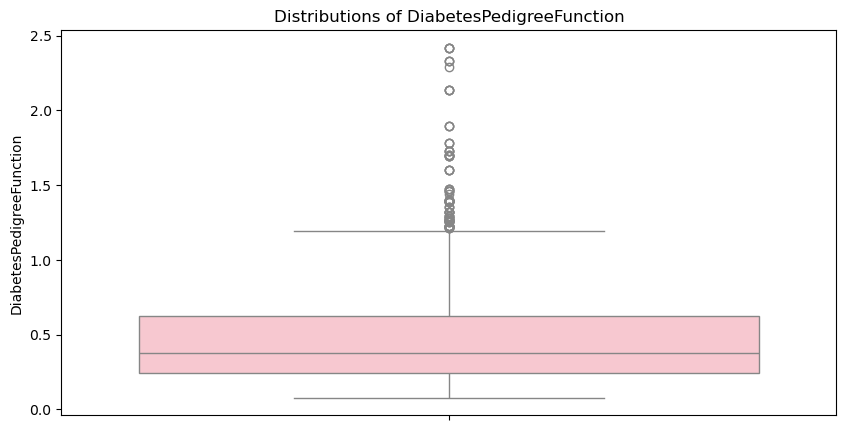

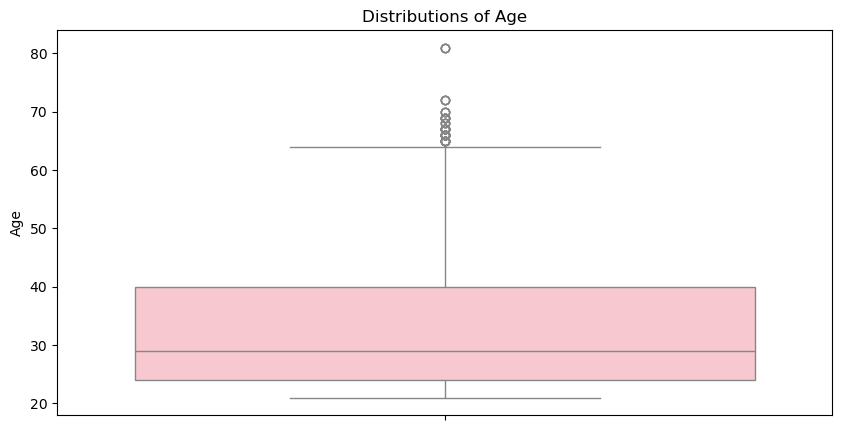

In [19]:
for col in X_train:
    plt.figure(figsize = (10, 5))
    sns.boxplot(data = df, y = col, color = "pink")
    # While "x = y" is somewhat illogical, it's important to know that "y" is the Outcome column.
    plt.title(f'Distributions of {col}')
    plt.show()

### Dataset imbalance

This section does not aim to remedy the imbalance yet, and merely documents its presence for now.

Outcome
0    1449
1     765
Name: count, dtype: int64


<Axes: xlabel='Outcome', ylabel='count'>

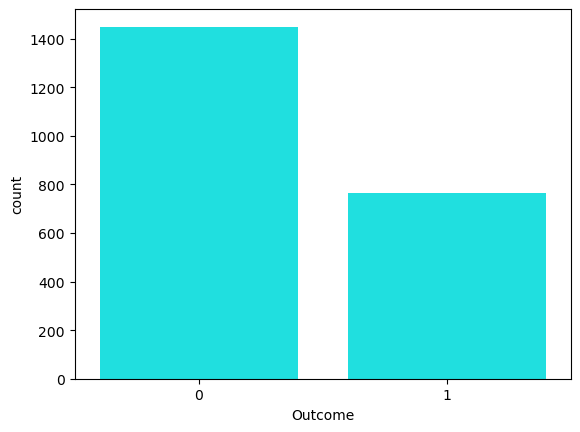

In [20]:
# We're only performing EDA on the training set. Y_train consists of the training set's Outcome column.
print(y_train.value_counts())
sns.countplot(X_train, x = y_train, color = "cyan")

### Multivariate analysis

#### Data Distributions by Outcome

##### Boxplots

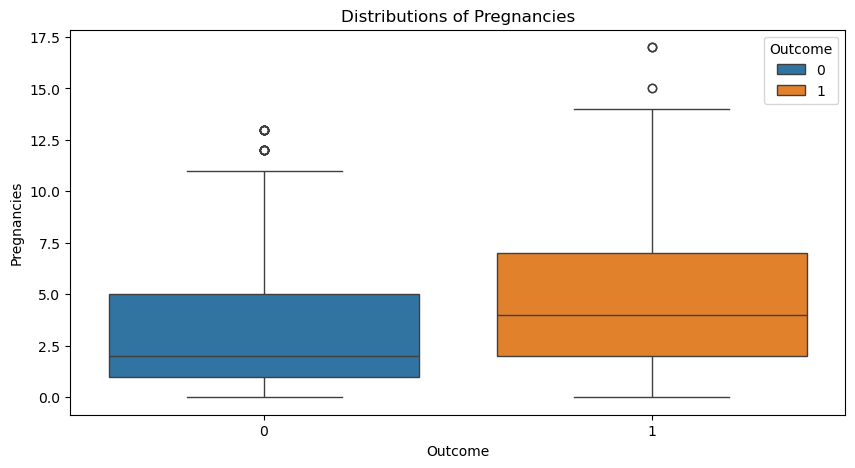

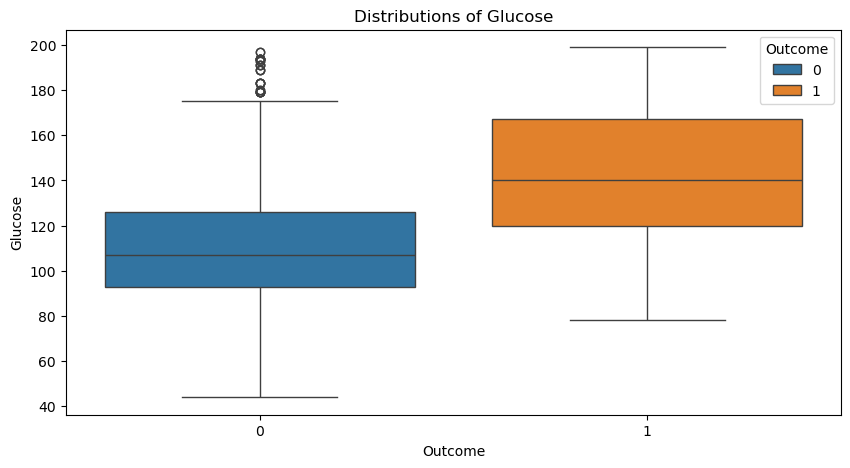

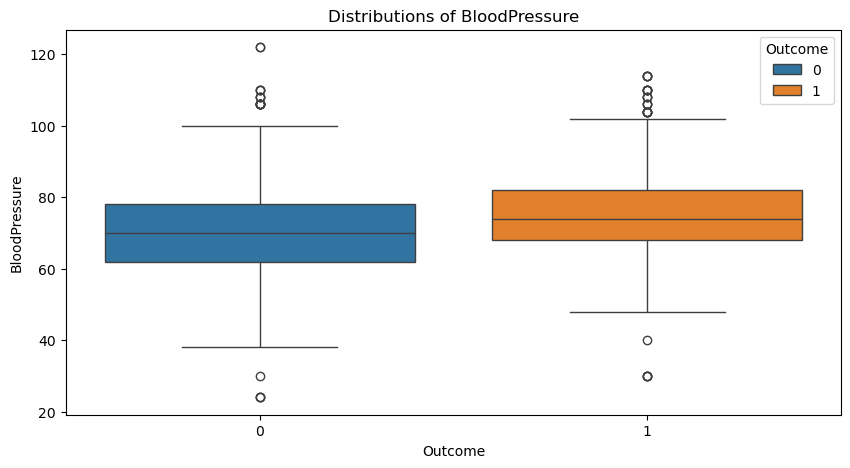

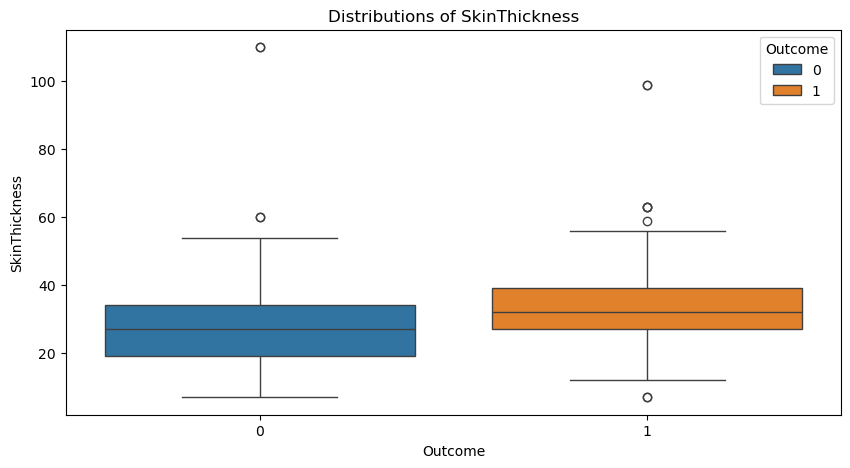

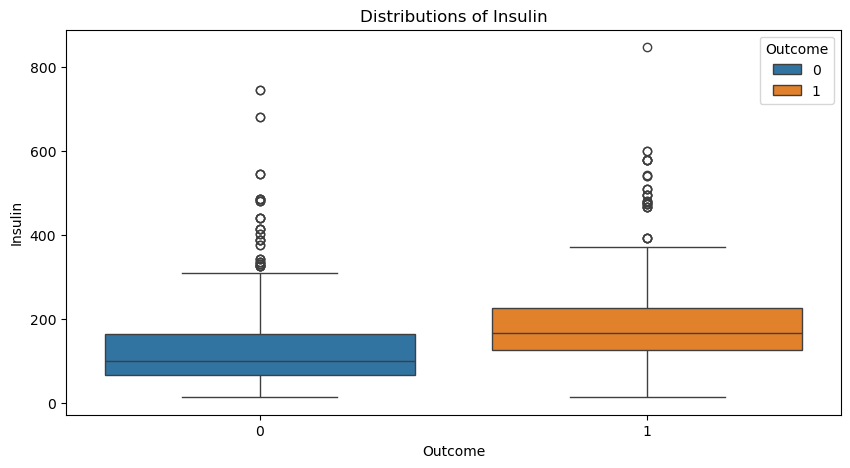

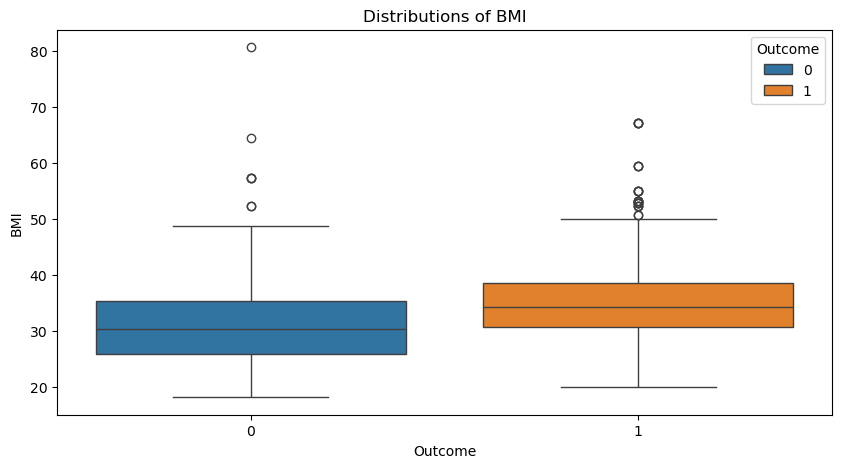

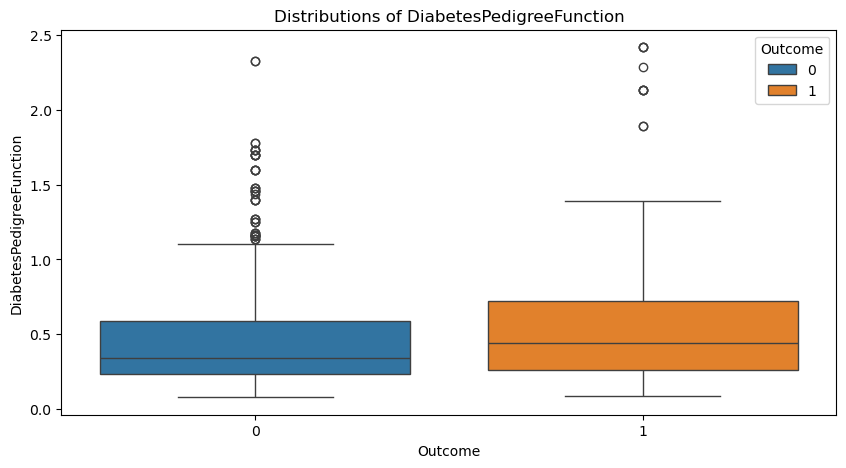

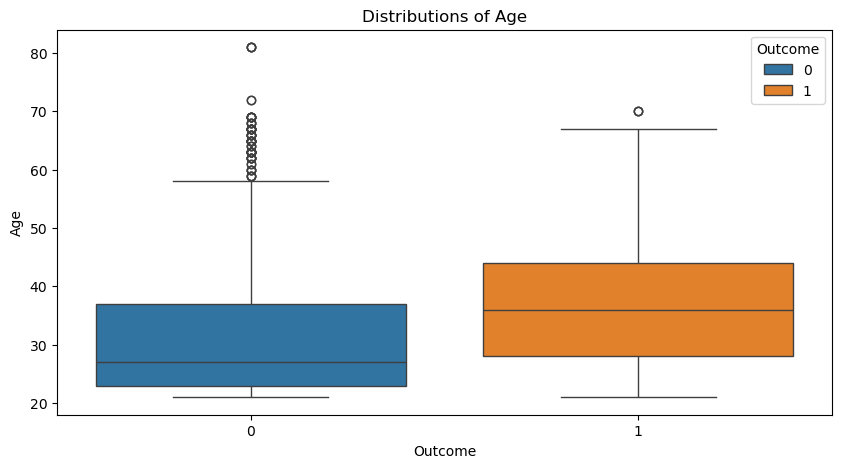

In [21]:
# Iterates through each column, producing a boxplot titled "Distributions of [column name]"
# Only iterates through X_train so that it doesn't produce one for the Outcome column itself.
for col in X_train:
    plt.figure(figsize = (10, 5))
    sns.boxplot(data = fullTrainSet, y = col, x = "Outcome", hue = "Outcome")
    plt.title(f'Distributions of {col}')
    plt.show()

##### Histograms

Another way to view data distributions is through histograms, which group data into "bins", and count the occurrence of data in each bin.

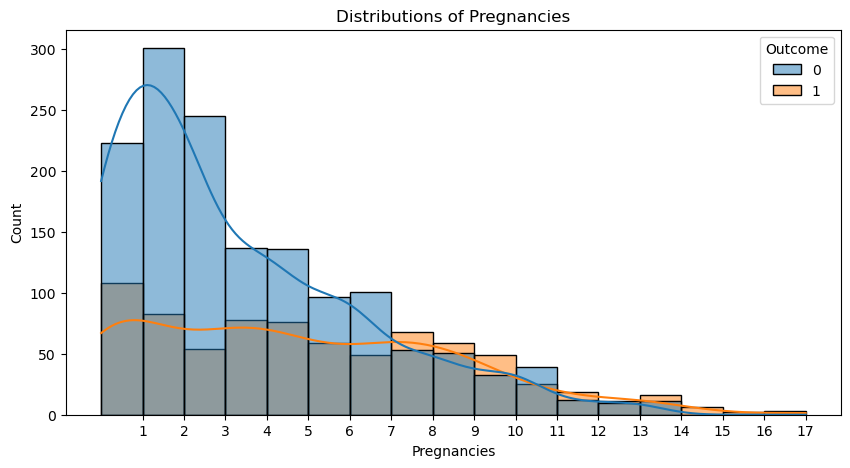

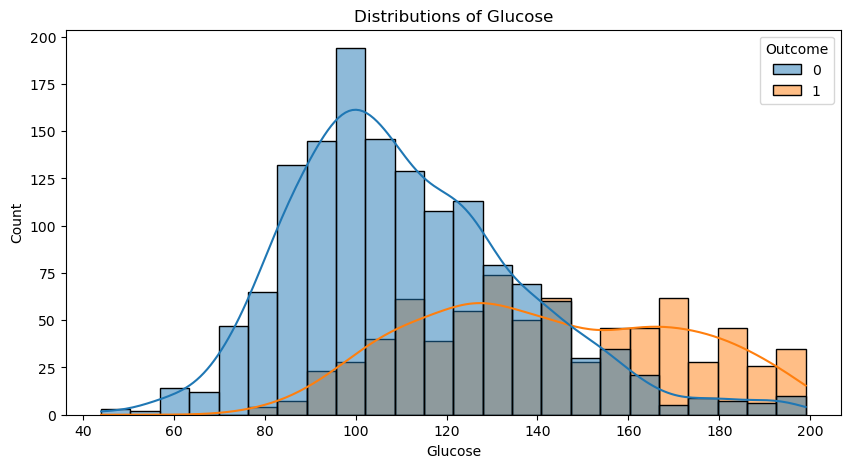

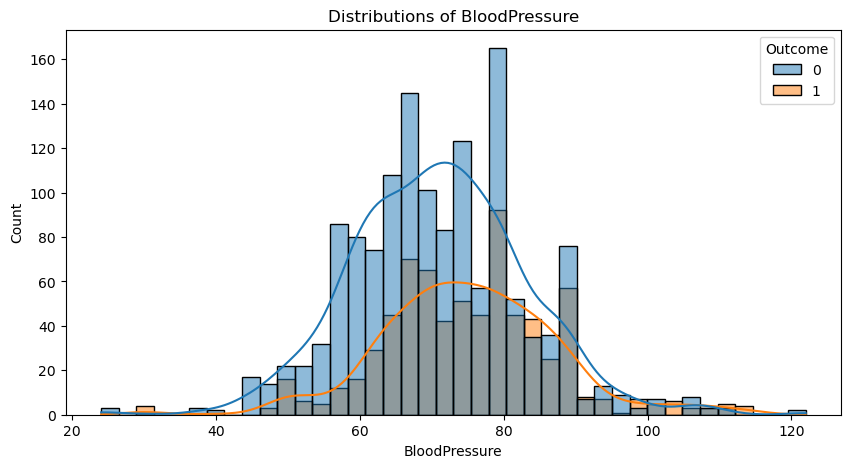

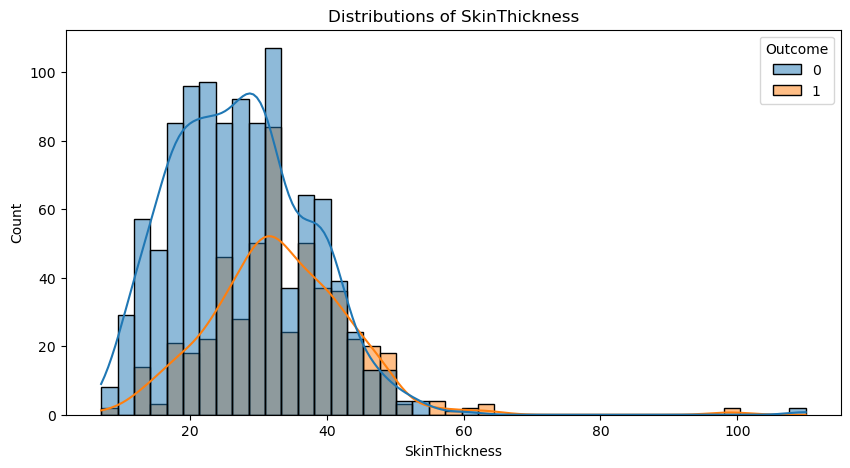

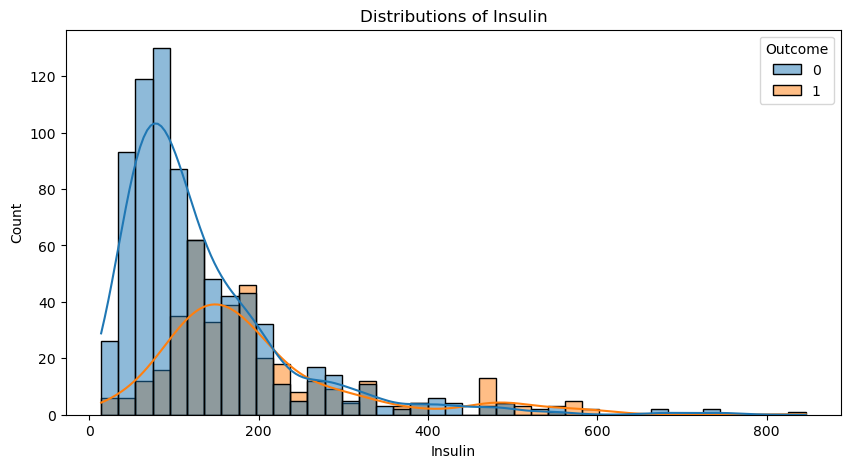

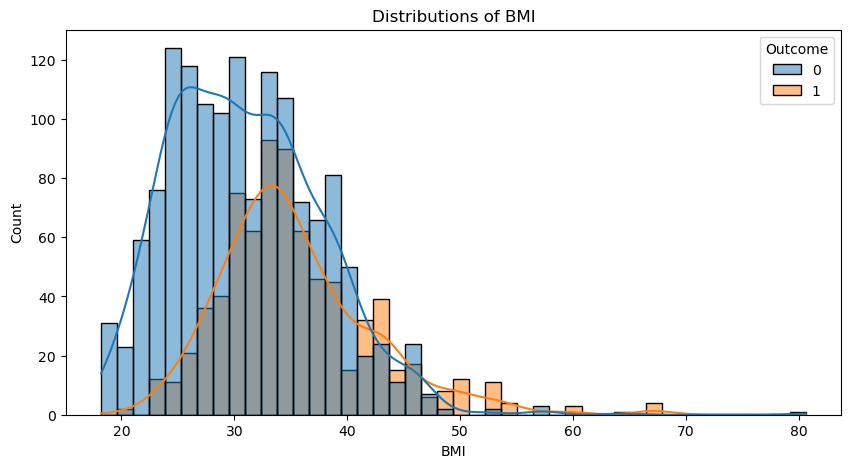

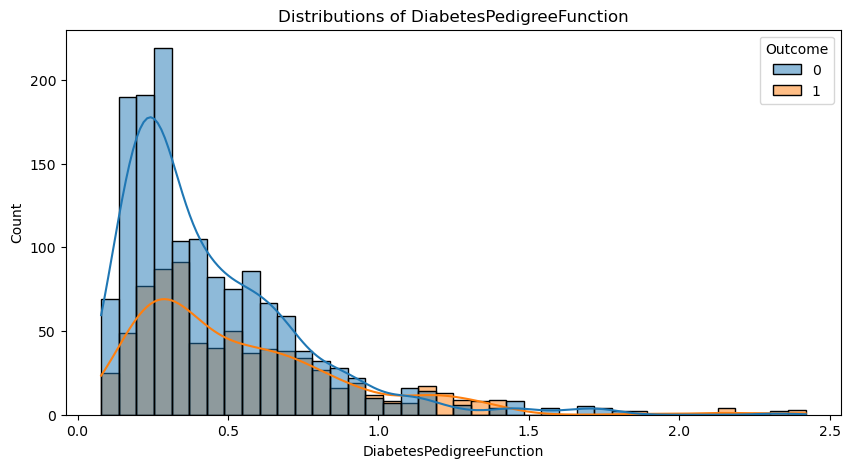

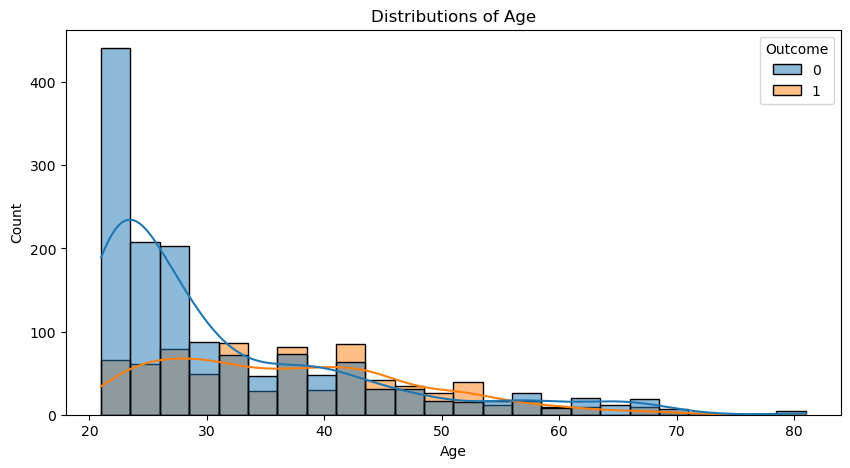

In [22]:
# Iterates through each column, producing a histogram titled "Distributions of [column name]"
# Only iterates through X_train so that it doesn't produce one for the Outcome column itself.
# KDE stands for Kernel Density Estimate. Setting it to true plots a line of best fit of the distribution.
for col in X_train:
    plt.figure(figsize = (10, 5))
    if col == "Pregnancies":
        # By default with Pregnancies, Seaborn will use decimal values in the X axis, creating a bad histogram.
        # Instead, set the bin width to 1, and the X axis to increment by 1, from 1 to 18.
        sns.histplot(data = fullTrainSet, x = col, kde = True, hue = "Outcome", binwidth = 1)
        plt.xticks(range(1, 18))
    else:
        # If it's any other column, use Seaborn's default X axis scale.
        sns.histplot(data = fullTrainSet, x = col, kde = True, hue = "Outcome")
    plt.title(f'Distributions of {col}')
    plt.show()

#### Pair plot

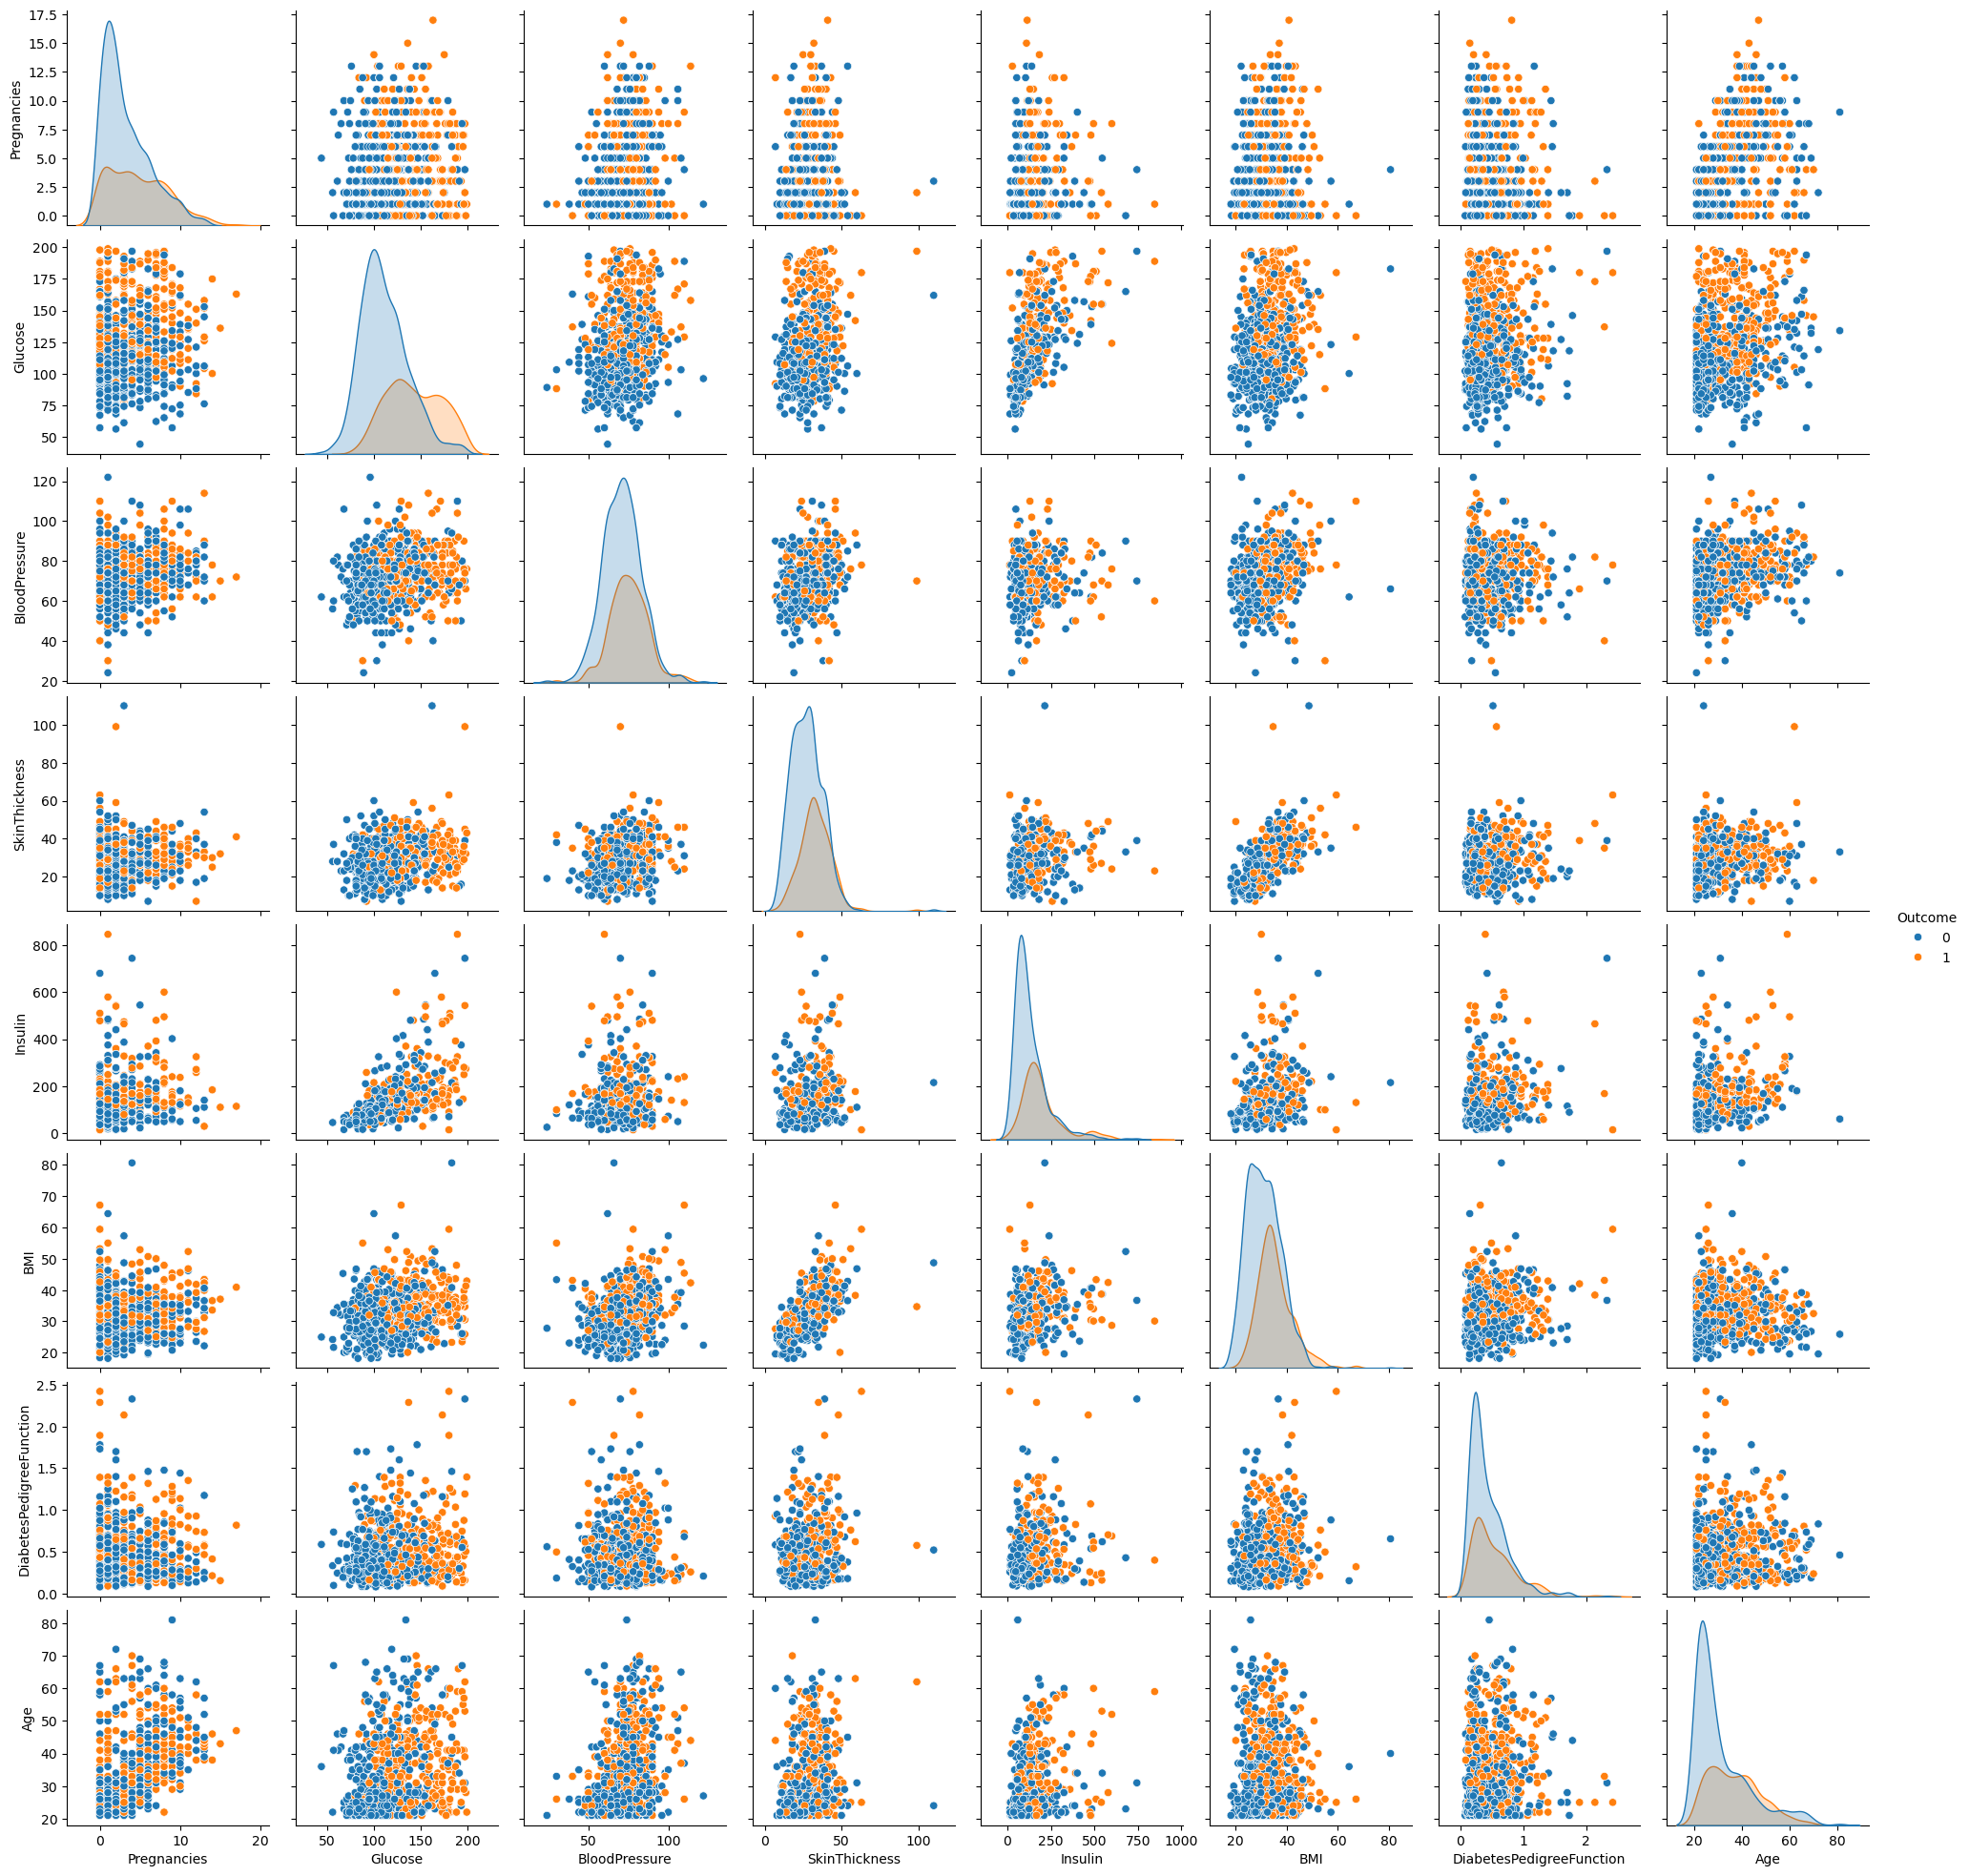

In [23]:
# Produces a pair plot of all columns, colouring each point by the outcome.
sns.pairplot(fullTrainSet, hue = "Outcome")

#### Correlation matrix

To see what factors influence each other, it is best to view a matrix of the entire dataset's correlations.

If only X_train is used, we will not be able to see the correlations between variables and the outcome, as this is excluded from X_train. Therefore, the "fullTrainSet" created earlier is use to also show the correlations for the outcome.

<Axes: >

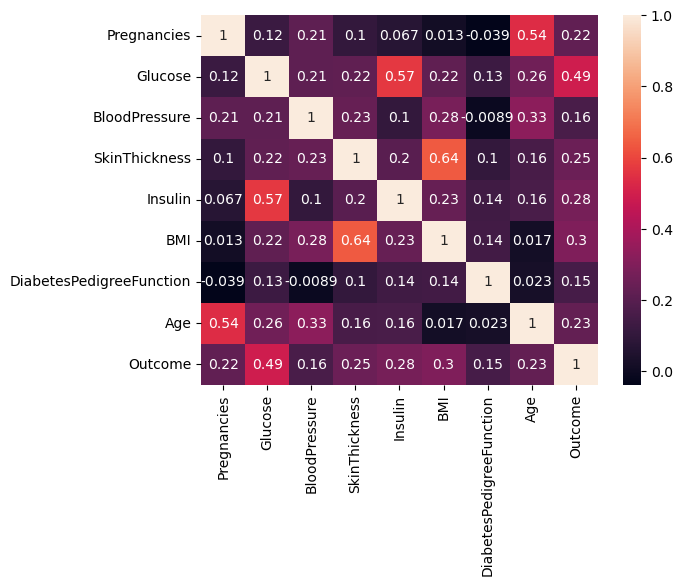

In [24]:
sns.heatmap(fullTrainSet.corr(), annot = True)

#### Insulin and Glucose relationship by Outcome

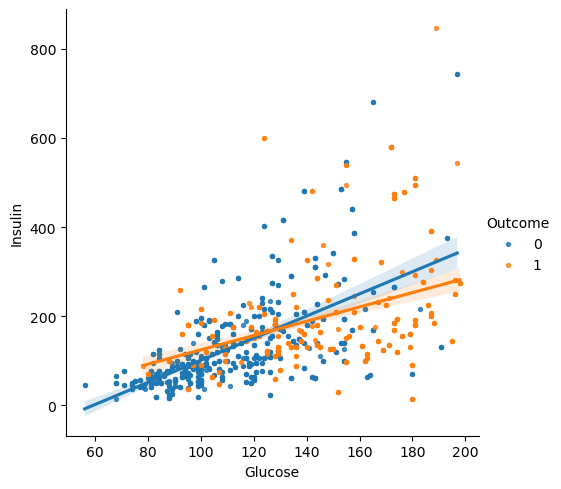

In [25]:
# Scatter plot using Linear Regression to produce a line of best fit.
# "scatter_kws" refers to keywords for the scatter points. "s: 5" makes the points smaller.
sns.lmplot(x = "Glucose", y = "Insulin", data = fullTrainSet, hue = "Outcome", scatter_kws={"s": 8})

## Data Preprocessing

This dataset does not need any data encoding as all features are already numerical.

### Data cleaning

#### Outlier handling

In [26]:
# DEBUGGING CELL, REMOVE IN FINAL. RECREATES TESTING SET WITH THE TRANSFORMATIONS IN EDA FOR MISSING VALUES.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train[["Glucose","Insulin","BloodPressure","SkinThickness","BMI"]] = X_train[["Glucose","Insulin","BloodPressure","SkinThickness","BMI"]].replace(0, np.nan)
X_test[["Glucose","Insulin","BloodPressure","SkinThickness","BMI"]] = X_test[["Glucose","Insulin","BloodPressure","SkinThickness","BMI"]].replace(0, np.nan)

To reduce the significant outliers in certain columns of the dataset, columns were constrained to their 1st and 99th percentiles, as the vast majority of the data was distributed evenly,
and there were only a small amount of outliers in comparison.

Rows with data points over these amounts were transformed into the upper bound, whereas rows below become the lower bound.

In [27]:
# Transforming rows under the 1st percentile or over the 99th percentile.
for column in X_train.columns:
    lowerBound = X_train[column].quantile(0.01)
    upperBound = X_train[column].quantile(0.99)
    # Where data in the column is less than the 1st percentile or more than the 99th,
    # transform it to the percentile.
    X_train[column] = np.clip(X_train[column], lowerBound, upperBound)
    # np.clip will make values lower than the lower bound into the lower bound,
    # and values over the upper bound into the upper bound.

#### Missing value handling

With the outliers now constrained, it is possible to impute missing values using a KNNImputer.

The KNN algorithm is described in Section 3.1.5 of the report. It uses data aggregated from the nearest data points to reach a conclusion; in an imputer,
it fills missing values with data from other nearby points. With the strong correlations between Glucose and Insulin, this can be especially useful as the Glucose data can be used to reach an accurate prediction of the missing Insulin data as described in Section 3.3.2.

In [28]:
# Creates a KNN Imputer that aggregates data from the 6 nearest neighbours to fill missing 
# data across the previously identified columns.
imputer = KNNImputer(n_neighbors = 6)

# Fit the imputer on the training data and transform missing values.
X_train = imputer.fit_transform(X_train)
# This converts X_train to a NumPy array, thereby removing the column names.
# This is solved by converting it back to a DataFrame with the column names
# of the original X.
X_train = pd.DataFrame(X_train, columns = X.columns)

# The imputer is not fitted to the testing set, and instead only transforms  
# missing rows within it.
X_test = imputer.transform(X_test)
# As with X_train, the column names are passed back by converting the 
# NumPy array to a DataFrame with the column names of the original X.
X_test = pd.DataFrame(X_test, columns = X.columns)

print(X_train.isna().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64


### Data scaling

The StandardScaler method of Scikit-Learn was used to standardise the data. A detailed description on what this process entails can be found in Section 3.3.3 of the report.

In [29]:
# Instantiate the scaler.
sc = StandardScaler()

# Fit the scaler to X_train and transform data in it.
X_train = sc.fit_transform(X_train)
# As with the imputer, the data can be made back into a
# DataFrame with column names.
X_train = pd.DataFrame(X_train, columns = X.columns)

# Only transform the testing data based on the fit from 
# the training set.
X_test = sc.transform(X_test)
# As with the imputer, the data can be made back into a
# DataFrame with column names.
X_test = pd.DataFrame(X_test, columns = X.columns)


X_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.069906,-0.422956,-0.706207,1.624799,-0.532573,0.344790,1.379999,-0.619707
1,-0.842302,-0.127229,-1.212881,0.759820,-0.585500,0.124244,-0.667264,-0.876417
2,-0.538233,0.037064,-2.057339,0.327330,0.166058,1.418111,0.156092,-0.619707
3,-0.234164,0.628518,-0.115086,0.615657,-0.001543,-0.360956,0.922226,-0.534137
4,1.286183,-1.244421,0.138251,0.219208,-0.950693,0.859396,-0.044184,0.492705


### Imbalance

The class imbalance is solved using the Synthetic Minority Oversampling Technique (SMOTE). SMOTE identifies the minority class, which is 1 (positive diabetes) in this dataset, and generates synthetic data for this class based on KNN. A further explanation is found in Section 3.3.4 of the report.

In [30]:
# Instantiate SMOTE, to be applied on the training set.
smote = SMOTE()

# View the original class imbalance.
print(y_train.value_counts())

# Fit SMOTE to the training set, and also generate data to balance it.
X_train, y_train = smote.fit_resample(X_train, y_train) 

# We can now see that the classes are balanced.
y_train.value_counts()

Outcome
0    1449
1     765
Name: count, dtype: int64


Outcome
1    1449
0    1449
Name: count, dtype: int64

## Model Development

### Fitting the models

In [125]:
# Creates 100 decision trees and aggregates their classifications, using the one 
# found most commonly across them.
rf = RandomForestClassifier(n_estimators = 100)

# Finds the optimal hyperplane to seperate classes by.
svc = SVC()

# Computes a weighted sum of all features and maps it to between 0 and 1 using a 
# sigmoid function. Rows over 0.5 are classified as 1, and rows under are classified as 0.
lr = LogisticRegression()

# Calculates the probability of diabetes based on the combination of features 
# and classifies based on the probability.
nb = GaussianNB()

# Classifies rows based on the 3 nearest data points.
knn = KNeighborsClassifier(n_neighbors = 3)

# Creating a list of the models so that they can be fitted in a for-loop.
models = [rf, svc, lr, nb, knn]

# Fits each model to the training dataset, where it will learn correlations and trends.
for model in models:
    model.fit(X_train, y_train)

### Results on Unseen Data 

#### Random Forest

Accuracy: 0.9765342960288809,
Recall: 0.967741935483871,
F1: 0.9651474530831099


<Axes: >

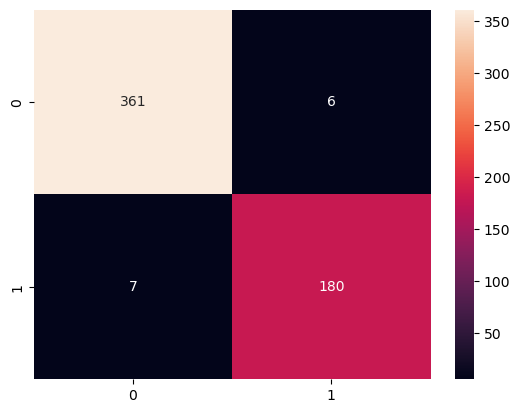

In [114]:
# Predicts the classification of every row in the testing set.
y_pred = rf.predict(X_test)

# Logs the three metrics used in the evaluation.
rf_acc = accuracy_score(y_pred, y_test)
rf_recall = recall_score(y_pred, y_test)
rf_f1 = f1_score(y_pred, y_test)

# Outputs the metrics of the model.
print(f"Accuracy: {rf_acc},\nRecall: {rf_recall},\nF1: {rf_f1}")

# Creates a confusion matrix, a visual interpretation of the 
# model's prediction. It contains true positives in the top left,
# false positives in the top right, false negatives in the bottom left,
# and true negatives in the bottom right.
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, fmt = "g")
# Setting the format to "g" makes the matrix use standard
# numerical noation (100) rather than scientific notation (1e+02)

#### Support Vector Machine (SVM)

In this context, it is a Support Vector **Classifier** (SVC) that is used because this is a classification problem. 

Accuracy: 0.8212996389891697,
Recall: 0.7018348623853211,
F1: 0.7555555555555555


<Axes: >

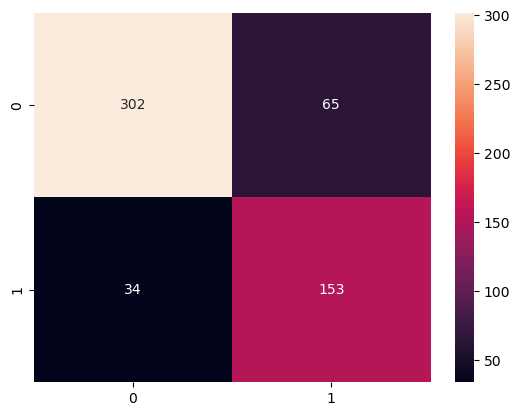

In [116]:
# Predicts the classification of every row in the testing set.
y_pred = svc.predict(X_test)

# Logs the three metrics used in the evaluation.
svc_acc = accuracy_score(y_pred, y_test)
svc_recall = recall_score(y_pred, y_test)
svc_f1 = f1_score(y_pred, y_test)

# Outputs the metrics of the model.
print(f"Accuracy: {svc_acc},\nRecall: {svc_recall},\nF1: {svc_f1}")

# Creates a confusion matrix, a visual interpretation of the 
# model's prediction. It contains true positives in the top left,
# false positives in the top right, false negatives in the bottom left,
# and true negatives in the bottom right.
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, fmt = "g")
# Setting the format to "g" makes the matrix use standard
# numerical noation (100) rather than scientific notation (1e+02)


#### Logistic Regression

Accuracy: 0.7418772563176895,
Recall: 0.6018518518518519,
F1: 0.6451612903225806


<Axes: >

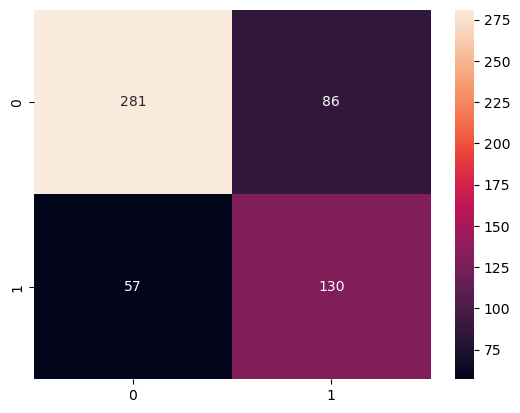

In [ ]:
# Predicts the classification of every row in the testing set.
y_pred = lr.predict(X_test)

# Logs the three metrics used in the evaluation.
lr_acc = accuracy_score(y_pred, y_test)
lr_recall = recall_score(y_pred, y_test)
lr_f1 = f1_score(y_pred, y_test)

# Outputs the metrics of the model.
print(f"Accuracy: {lr_acc},\nRecall: {lr_recall},\nF1: {lr_f1}")

# Creates a confusion matrix, a visual interpretation of the 
# model's prediction. It contains true positives in the top left,
# false positives in the top right, false negatives in the bottom left,
# and true negatives in the bottom right.
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, fmt = "g")
# Setting the format to "g" makes the matrix use standard
# numerical noation (100) rather than scientific notation (1e+02)

#### Naive Bayes

Accuracy: 0.7436823104693141,
Recall: 0.6046511627906976,
F1: 0.6467661691542289


<Axes: >

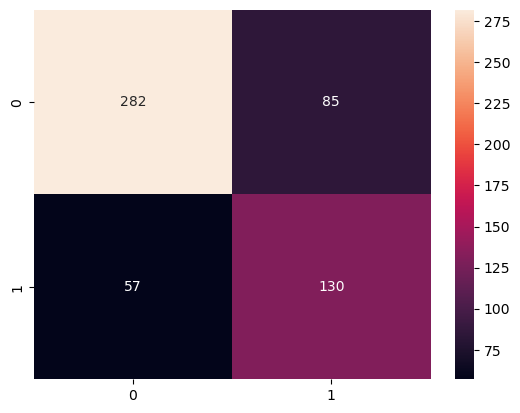

In [120]:
# Predicts the classification of every row in the testing set.
y_pred = nb.predict(X_test)

# Logs the three metrics used in the evaluation.
nb_acc = accuracy_score(y_pred, y_test)
nb_recall = recall_score(y_pred, y_test)
nb_f1 = f1_score(y_pred, y_test)

# Outputs the metrics of the model.
print(f"Accuracy: {nb_acc},\nRecall: {nb_recall},\nF1: {nb_f1}")

# Creates a confusion matrix, a visual interpretation of the 
# model's prediction. It contains true positives in the top left,
# false positives in the top right, false negatives in the bottom left,
# and true negatives in the bottom right.
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, fmt = "g")
# Setting the format to "g" makes the matrix use standard
# numerical noation (100) rather than scientific notation (1e+02)

#### K-Nearest Neighbours (KNN)

Accuracy: 0.7436823104693141,
Recall: 0.6046511627906976,
F1: 0.6467661691542289


<Axes: >

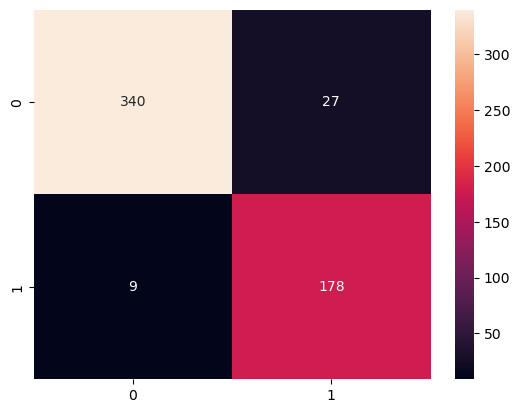

In [122]:
# Predicts the classification of every row in the testing set.
y_pred = knn.predict(X_test)

# Logs the three metrics used in the evaluation.
knn_acc = accuracy_score(y_pred, y_test)
knn_recall = recall_score(y_pred, y_test)
knn_f1 = f1_score(y_pred, y_test)

# Outputs the metrics of the model.
print(f"Accuracy: {nb_acc},\nRecall: {nb_recall},\nF1: {nb_f1}")

# Creates a confusion matrix, a visual interpretation of the 
# model's prediction. It contains true positives in the top left,
# false positives in the top right, false negatives in the bottom left,
# and true negatives in the bottom right.
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, fmt = "g")
# Setting the format to "g" makes the matrix use standard
# numerical noation (100) rather than scientific notation (1e+02)

### Results on seen data (All models)

The models were given samples of the training data which they have already seen to test their predictions.

Accuracy: 1.0,
Recall: 1.0,
F1: 1.0


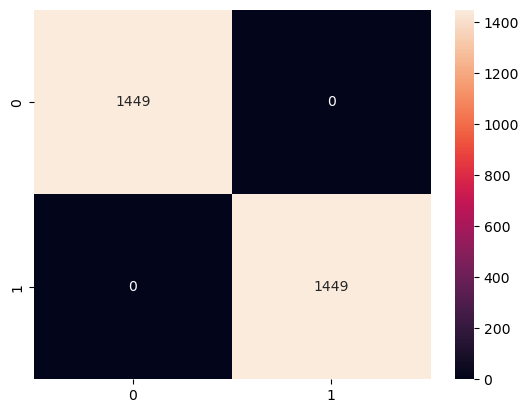

Accuracy: 0.8695652173913043,
Recall: 0.8484059856864021,
F1: 0.8734092431346283


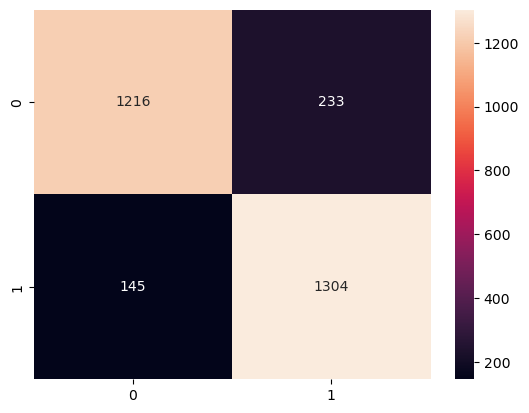

Accuracy: 0.7550034506556246,
Recall: 0.7622427253371186,
F1: 0.7515745276417075


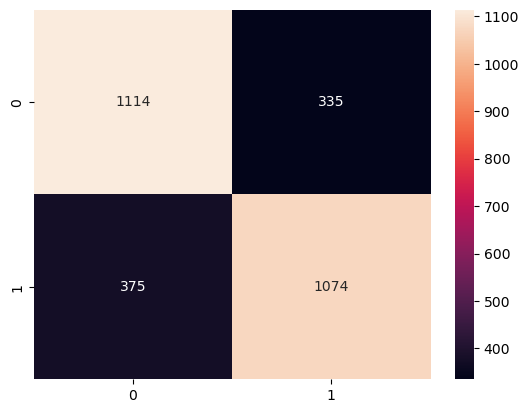

Accuracy: 0.7198067632850241,
Recall: 0.7382198952879581,
F1: 0.7085427135678392


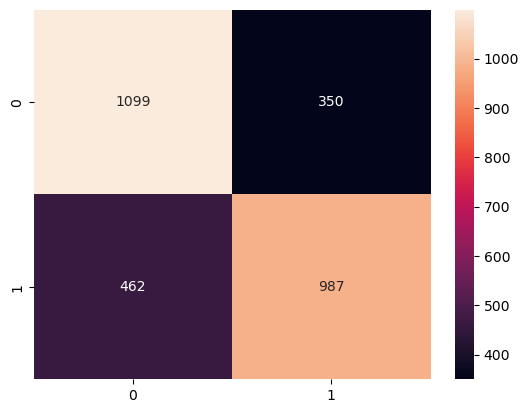

Accuracy: 0.994824016563147,
Recall: 0.9910958904109589,
F1: 0.994843588862152


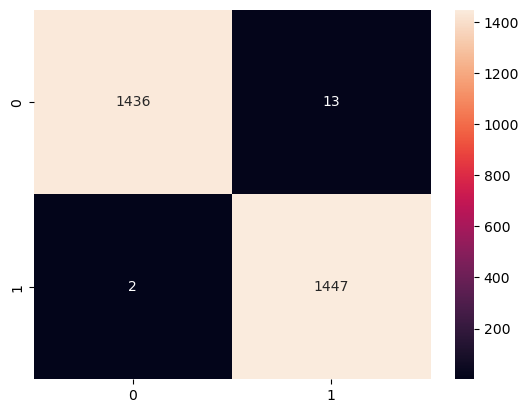

In [124]:
# Predict on the training set with all five models.
rf_seen_pred = rf.predict(X_train)
svc_seen_pred = svc.predict(X_train)
lr_seen_pred = lr.predict(X_train)
nb_seen_pred = nb.predict(X_train)
knn_seen_pred = knn.predict(X_train)

# Save a list of the predictions to iterate through.
predictions = [rf_seen_pred, svc_seen_pred, lr_seen_pred,
               nb_seen_pred, knn_seen_pred]

# Iterate through each model, outputting it's accuracy,
# recall and F1-Score, also producing a confusion matrix.
for pred in predictions:
    acc = accuracy_score(pred, y_train)
    recall = recall_score(pred, y_train)
    f1 = f1_score(pred, y_train)
    cm = confusion_matrix(y_train, pred) # Confusion matrix takes parameters in the inverse order.
    
    # Output the metrics.
    print(f"Accuracy: {acc},\nRecall: {recall},\nF1: {f1}")
    
    # Create the matrix.
    sns.heatmap(cm, annot = True, fmt = "g")
    # Each matrix needs to be individually printed. If this line
    # wasn't used, Seaborn would try to produce one overall matrix.
    plt.show()


## DELETE SECTION??? Model Evaluation (First iteration)

The models will be reproduced with improvements following this section, hence the "First iteration"

In [65]:
# Creating a DF to hold all models and associated eval metrics for plotting.
# It is done in this repetitive way so that Seaborn can easily produce a grouped bar plot from it.
evalDf = pd.DataFrame({
    "Model": ["Random Forest", "Random Forest", "Random Forest",
               "SVM", "SVM", "SVM",
               "LR", "LR", "LR",
               "Naive Bayes", "Naive Bayes", "Naive Bayes",
               "KNN", "KNN", "KNN"],
    
    "Metric": ["Accuracy", "Recall", "F1-Score",
                "Accuracy", "Recall", "F1-Score",
                "Accuracy", "Recall", "F1-Score",
                "Accuracy", "Recall", "F1-Score",
                "Accuracy", "Recall", "F1-Score"],
    
    "Score": [rf_acc, rf_recall, rf_f1,
              svc_acc, svc_recall, svc_f1,
              lr_acc, lr_recall, lr_f1,
              nb_acc, nb_recall, nb_f1,
              knn_acc, knn_recall, knn_f1]
})

<Axes: xlabel='Model', ylabel='Score'>

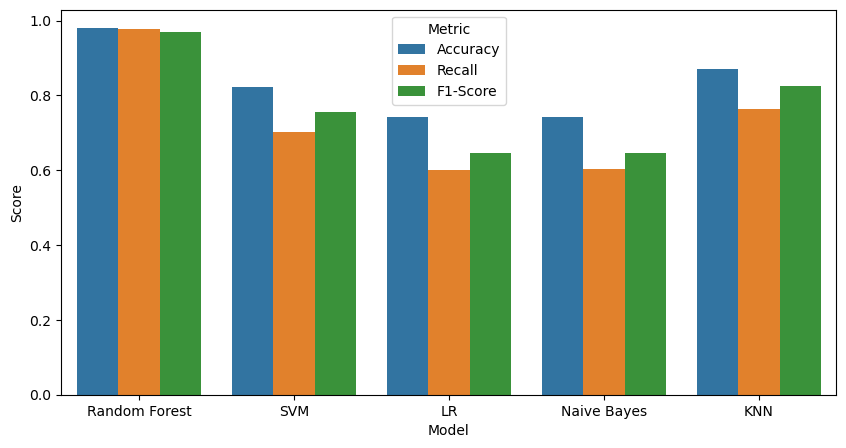

In [66]:
plt.figure(figsize= (10, 5))
sns.barplot(evalDf, x = "Model", y = "Score", hue = "Metric")

## Iteration 2

Following the evaluation conducted in Chapter 5 of the report, key issues were identified throughout the process. This section will repeat the preprocessing and model training steps, using an updated strategy to maximise model performance.

### GridSearchCV

GridSearchCV takes a list of parameters and trains models using combinations of each, exhaustively evaluating each one and returning the best set of parameters based on the performances of the models it trained on each combination. This takes a lot of time and computational power.

The parameters for each algorithm were identified on their associated Scikit-Learn documentation page:
- Random Forest: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- Support Vector Classifier: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html 
- Logistic Regression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression
- Naive Bayes: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB
- K-Nearest Neighbours: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [191]:
# Initialises the parameter grids for each model. Each parameter listed here and 
# each combination of them will be tested and evaluated, with the best one being returned.

# The tweakable parameters were identified from the Scikit-Learn documentation of each model.
param_grids = {
    'Random Forest': {
        'n_estimators': [1, 2, 3, 5, 10, 25, 50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [1, 2, 3, 5]
    },
    'Support Vector Classifier': {
        'C': [0.1, 1, 3],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    'Logistic Regression': {
        'C': [0.1, 1, 3, 5, 10],
        'solver': ['liblinear', 'lbfgs', 'newton-cholesky', 'newton-cg', 'sag', 'saga']
    },
    
    # GaussianNB doesn't have any tweakable hyperparameters that will benefit this analysis,
    # but it still has an entry here to prevent an error with an upcoming for-loop. The only parameters
    # it has are "priors" for pre-existing probabilities and "var_smoothing" for calculation 
    # stability, though neither of these will be useful in this classification.
    "Naive Bayes": {},
    
    'K-Nearest Neighbors': {
        'n_neighbors': [3, 5, 10, 25, 50, 100, 200],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
}

# The GridSearchCV object isn't instantiated here, because a new one 
# will need to be made for each model. This will be done in a for-loop later.

In [192]:
# Initialising new models. This is set up as a dictionary for use with the param_grids.
models = {
    'Random Forest': RandomForestClassifier(random_state = 42),
    'Support Vector Classifier': SVC(random_state = 42),
    'Logistic Regression': LogisticRegression(random_state = 42),
    'Naive Bayes': GaussianNB(), 
    'K-Nearest Neighbors': KNeighborsClassifier()
}
# Note that no parameters other than the random_state of models that use randomness
# are set here, as GridSearchCV will do this later.

### StratifiedKFold

Stratified KFold is... A further description can be found in Appendix D of the report.

In [193]:
# Initialise the StratifiedKFold with 10 splits.
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

# Set the scoring parameters, as StratifiedKFold normally only uses Accuracy,
# but it was established that Recall and F1 will be used in evaluating each model.
metrics = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score), 
    'f1': make_scorer(f1_score)          
}

### Second Iteration Models

Now that the parameter grids and the cross validator (StratifiedKFold) are set up, the models can be retrained, tested and evaluated.

Tuning hyperparameters for Random Forest
Best parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validated F1 Score: 0.9838

Random Forest Accuracy on testing set: 0.9819
Random Forest Recall on testing set: 0.9626
Random Forest F1 Score on testing set: 0.9730


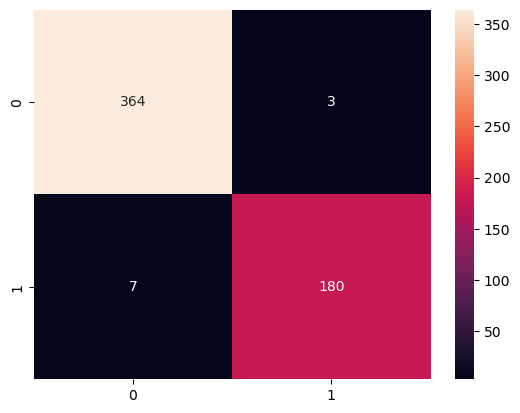

Tuning hyperparameters for Support Vector Classifier
Best parameters for Support Vector Classifier: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validated F1 Score: 0.9744

Support Vector Classifier Accuracy on testing set: 0.9874
Support Vector Classifier Recall on testing set: 0.9626
Support Vector Classifier F1 Score on testing set: 0.9809


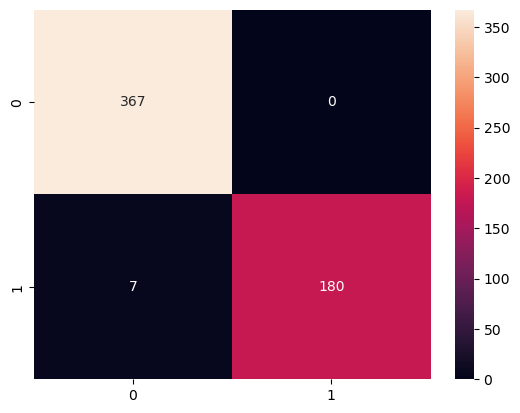

Tuning hyperparameters for Logistic Regression
Best parameters for Logistic Regression: {'C': 0.1, 'solver': 'lbfgs'}
Best cross-validated F1 Score: 0.6519

Logistic Regression Accuracy on testing set: 0.7726
Logistic Regression Recall on testing set: 0.5187
Logistic Regression F1 Score on testing set: 0.6062


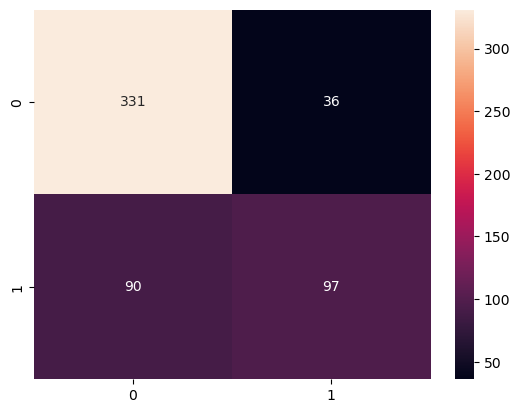

Tuning hyperparameters for Naive Bayes
Best parameters for Naive Bayes: {}
Best cross-validated F1 Score: 0.6341

Naive Bayes Accuracy on testing set: 0.7690
Naive Bayes Recall on testing set: 0.5936
Naive Bayes F1 Score on testing set: 0.6343


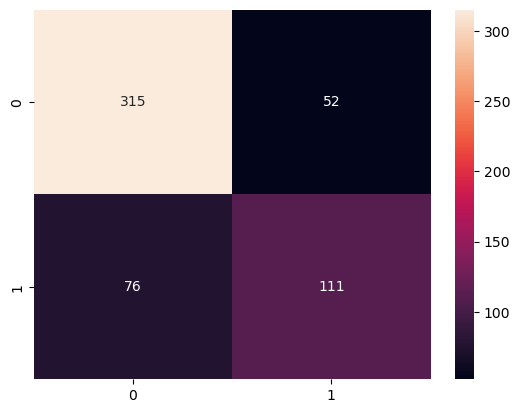

Tuning hyperparameters for K-Nearest Neighbors
Best parameters for K-Nearest Neighbors: {'metric': 'euclidean', 'n_neighbors': 200, 'weights': 'distance'}
Best cross-validated F1 Score: 0.9855

K-Nearest Neighbors Accuracy on testing set: 0.9838
K-Nearest Neighbors Recall on testing set: 0.9626
K-Nearest Neighbors F1 Score on testing set: 0.9756


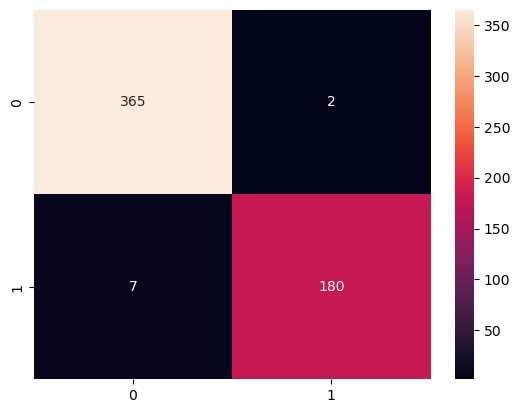

In [194]:
# Creating a list to hold each of the best models produced during 
# this process.
bestModels = []

# For each model in the previously set models dictionary, run GridSearchCV to find the optimal parameter based on 
# the parameter grid for the model of that name. Then, test it on th
for model_name, model in models.items():
    print(f"Tuning hyperparameters for {model_name}")
    
    grid_search = GridSearchCV(
        estimator = model, # The current model in the loop. Starts with Random Forest, then SVC, etc.
        param_grid = param_grids[model_name], # Using the parameter grid previously set.
        cv = skf, # Using the StratifiedKFold for cross-validation
        scoring = metrics, # Scoring the model on Accuracy, Recall and F1.
        refit = 'f1', # F1 score is one of the most important metrics, as discussed in Section 3.2.
        # As such, GridSearchCV will now aim to maximise the F1 score.
        n_jobs = -1 # Use all available CPU cores. 
    )
    
    # Fit the model with the best parameters to the training set.
    grid_search.fit(X_train, y_train)
    
    # Output the best parameters for the model based on those used in the best model.
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validated F1 Score: {grid_search.best_score_:.4f}\n") # Newline at the end to space the metrics.
    # :.4f means the metric will be trimmed to 4 decimal places.
    
    # Selects the model with the highest F1 score.
    best_model = grid_search.best_estimator_ 
    
    # Make predictions on the testing set with the best model.
    y_pred = best_model.predict(X_test)
    
    # Get the metrics of the predictions.
    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred,)  
    f1 = f1_score(y_test, y_pred) 
    
    # Output the metrics.
    print(f"{model_name} Accuracy on testing set: {acc:.4f}")
    print(f"{model_name} Recall on testing set: {recall:.4f}")
    print(f"{model_name} F1 Score on testing set: {f1:.4f}")
    
    # Also produce a confusion matrix of its predictions.
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot = True, fmt = "g") # fmt = "g" avoids scientific notation.
    
    # Each matrix needs to be individually printed. If this line
    # wasn't used, Seaborn would try to produce one overall matrix.
    plt.show()
    
    # Add the model to the list of models so that it can be referenced later.
    bestModels.append(best_model)

In [162]:
# Unpack the list of models so that they can be used outside of the for loop.
rf_Iteration2, svc_Iteration2, lr_Iteration2, nb_Iteration2, knn_Iteration2 = bestModels
# Python automatically unpacks the list if the amount of variables assigned is equal to the list's length.


# Model Prediction Suite

This section of the notebook allows for the input of data to receive a prediction from the Iteration 2 models.

In [184]:
def outputMsg(pred):
    print(pred)
    if pred[0] == 0:
        return "this person does NOT have diabetes mellitus."
    else:
        return "this person DOES have diabetes mellitus."

def predictWithAll(data):
    try:
        data = np.array(data)
        data = data.reshape(1, -1)
        data = sc.transform(data)
        print(data)
        
        # [MODEL NAME] predicts that this person DOES/does NOT have diabetes mellitus.
        # outputMsg(model.predict(data)) first calls the model to predict based on the input data,
        # then based on what is returned by the prediction, outputs either message in outputMsg().
        print(f"Random Forest predicts that {outputMsg(rf_Iteration2.predict(data))}")
        print(f"Support Vector Classifier predicts that {outputMsg(svc_Iteration2.predict(data))}")
        print(f"Linear Regression predicts that {outputMsg(lr_Iteration2.predict(data))}")
        print(f"Naive Bayes predicts that {outputMsg(nb_Iteration2.predict(data))}")
        print(f"K-Nearest Neighbours predicts that {outputMsg(knn_Iteration2.predict(data))}")
        
    except:
        print("The data entered is not of the correct format.")
        return 
    

RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42)

In [189]:
# This example row is the first row of the testing set.
# Features go in order of:
# Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age.
data = [4, 109, 64, 44, 99, 34.8, 0.905, 26]

predictWithAll(data)

[[ 0.06990571 -0.42295646 -0.70620653  1.62479949 -0.53257307  0.34478973
   1.37999904 -0.61970703]]
[0]
Random Forest predicts that this person does NOT have diabetes mellitus.
[0]
Support Vector Classifier predicts that this person does NOT have diabetes mellitus.
[0]
Linear Regression predicts that this person does NOT have diabetes mellitus.
[0]
Naive Bayes predicts that this person does NOT have diabetes mellitus.
[0]
K-Nearest Neighbours predicts that this person does NOT have diabetes mellitus.


In [188]:
X_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
2124,4,109,64,44,99,34.8,0.905,26
2716,1,118,58,36,94,33.3,0.261,23
2232,2,123,48,32,165,42.1,0.520,26
261,3,141,0,0,0,30.0,0.761,27
2059,8,84,74,31,0,38.3,0.457,39


In [187]:
y_train.head()

2124    1
2716    0
2232    0
261     1
2059    0
Name: Outcome, dtype: int64